In [233]:
import os
import time
import datetime
import json
import shutil
import numpy as np
import pandas as pd
from pathlib import Path
import math
import PIL
from PIL import Image

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go

from sklearn.cluster import OPTICS,  DBSCAN, Birch 

import torch
from torch import nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
from util.pos_embed import interpolate_pos_embed
from util import datasets as util_datasets

import models_mae
import models_vit

print(np.__version__)
print(pd.__version__)
print(torch.__version__)


path_meta = Path('meta')
path_meta.mkdir(exist_ok=True, parents=True)
path_embeddings = Path('embedding')
path_embeddings.mkdir(exist_ok=True, parents=True)

1.22.2
1.4.1
1.10.2+cu113


## Prepare data

In [21]:
encoder_version='eBirdFT' # 'iNatFT', 'eBirdFT' or 'eBirdPT',
norm_pixel = 'on'

global_pool = False
token = 'cls' if global_pool==False else 'gap'
data_src = 'eBirdTop100' #  'iNat', 'eBird', 'eBirdTop100'

path_model = Path('output_dir')

print(f'Encoder  : {encoder_version}')
if encoder_version=='iNatFT':
    ck = path_model/'ebird_NPon_FT_cls_vit_base_checkpoint-99.pth'   #　iNaturalist finetuned MAE
    n_classes = 1486
elif encoder_version=='eBirdPT':
    ck = path_model/'ebird_LP_cls_2fc_vit_base_checkpoint-89.pth'   #　Ebird pretrained MAE
    n_classes =1486
elif encoder_version=='eBirdFT':
    ck = path_model/'ebird_NPon_eBirdFT_cls11186_vit_base_checkpoint-49.pth'  #　eBird finetuned MAE
    n_classes = 11186

v_embedding = f'NP{norm_pixel}(Pretrain)_{encoder_version}{token}(Encoder)_{data_src}(Data)'
print(f'Embedding version : {v_embedding}')

 

Encoder  : eBirdFT
Embedding version : NPon(Pretrain)_eBirdFTcls(Encoder)_eBirdTop100(Data)


In [27]:
%%time

# data_path = '../../shared/iNaturalist_2021'

# if data_src == 'eBird':
#     val_data = 'val_ebird'
#     meta_data =  '../../shared/iNaturalist_2021/meta/val_ebird.csv'
# elif data_src == 'iNat':
#     val_data = 'val'
#     meta_data =  '../../shared/iNaturalist_2021/meta/val.csv'
# elif  data_src == 'eBirdTop100':
#     data_path = '../../shared/eBird/download_ebird/downloaded'
#     val_data = 'jpg_top100'
#     meta_data =  '../../shared/eBird/download_ebird/meta/jpg_top100_meta5.csv'
    
# val_data = 'ebird_finetune/train'
# imgs_path = Path(data_path, val_data)
# # imgs_path = Path('../../shared/iNaturalist_2021/val_ebird')
# print(imgs_path)
# files_path_ = [f for f in imgs_path.glob('**/*') if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]

# # exlude .ipynb files
# files_path_ = [f for f in files_path_ if not f.name.startswith('.')] 
# files_path_.sort()

# print(f'Meta data :  "{Path(meta_data).name}"')

CPU times: user 7 µs, sys: 6 µs, total: 13 µs
Wall time: 22.4 µs


In [189]:
files_path_  = list(data_path + '/' +  val_data + '/' + df_meta.Dir_FName	+ '.jpg')
labels = df_meta.Label.values

print(len(files_path_ ))
assert len(files_path_) == len(labels)
assert  df_meta.Label.dtype == 'int64'

896555


### Load meta

In [191]:
%%time
assert data_src == 'eBirdTop100'

meta_data =  '../../shared/eBird/download_ebird/meta/jpg_top100_meta5.feather'
df_meta =  pd.read_feather(meta_data)

In [225]:
%%time
# Establish sp_id  
if data_src == 'eBirdTop100':
    col_obj2cat = ['Format', 'Accessory', 'Asset_State', 'isInternalUser', 'mediaDownloadUrl', 'Playback', 'Microphone', 'Recorder', 'Taxon_Category', 
                   'Age/Sex', 'Asset_Tags', 'Order', 'Behaviors', 'Country', 'Parent_Dir', 'Family', 'Background_Species', 'Genus', 'State', 'County']
    for col in col_obj2cat :
        df_meta[col] =  df_meta[col].astype('category') 
    
    col_label = ['Label'] 
    col_basic = ['ML_Catalog_Number', 'Dir_FName']
    col_file = ['Dir_FName', 'Parent_Dir', 'Sci_N']
    col_taxon = ['Order', 'Family', 'Genus', 'SCI_NAME_2021', 'Sci_Name', 'Parent_Species', 'Taxon_Category']
    col_geo = ['Country', 'Latitude', 'Longitude']
    col_time = ['Year', 'Month', 'Day']
    col_sel = col_label + col_basic + col_taxon + col_geo + col_time
    df_meta = df_meta[col_sel].copy()
elif data_src == 'iNat' or  data_src == 'eBird':
    df_meta.set_axis(df_meta.columns.str.capitalize(), axis='columns', inplace=True)
    df_meta.rename({'Scientific Name':'Sci_Name'}, axis='columns', inplace=True)
    df_meta['Sci_Name'] = df_meta.Genus + '_' + df_meta.Specific_epithet
    df_meta.sort_values(by=['File_name'], inplace=True)
    
print(f'# of Order : {df_meta.Order.nunique()}')
print(f'# of Family : {df_meta.Family.nunique()}')
print(f'# of Genus: {df_meta.Genus.nunique()}')

print(df_meta.columns)

KeyError: 'Format'

#### data filter by `Taxon Category`
- selected: 'Species', 'Group', 'Intergrade', 'Form', 'Domestic'
- excluded: 'Spuh', 'Slash', 'Hybrid'

##### reference
- [The eBird Taxonomy](https://ebird.org/science/use-ebird-data/the-ebird-taxonomy)

In [29]:
df_meta.query('Label<0')

,Label,ML_Catalog_Number,Dir_FName,Order,Family,Genus,SCI_NAME_2021,Sci_Name,Parent_Species,Taxon_Category,Country,Latitude,Longitude,Year,Month,Day,Average_Community_Rating,Number_of_Ratings
16636,-1,196733901,Accipitridae/Buteo_buteo_86_196733901,Accipitriformes,Accipitridae,NaN,Geranoaetus/Buteo sp.,Geranoaetus/Buteo sp.,Geranoaetus/Buteo sp.,Spuh,Colombia,4.9693,-75.3803,2020.0,1.0,2.0,0.0,0.0
16637,-1,105997691,Accipitridae/Buteo_buteo_87_105997691,Accipitriformes,Accipitridae,NaN,Buteo/eagle sp.,Buteo/eagle sp.,Buteo/eagle sp.,Spuh,India,13.7625,77.4948,2018.0,6.0,23.0,2.0,1.0
16638,-1,110872831,Accipitridae/Buteo_buteo_87_110872831,Accipitriformes,Accipitridae,NaN,Buteo/eagle sp.,Buteo/eagle sp.,Buteo/eagle sp.,Spuh,Oman,17.0137,54.1774,2012.0,11.0,14.0,0.0,0.0
16639,-1,112307261,Accipitridae/Buteo_buteo_87_112307261,Accipitriformes,Accipitridae,NaN,Buteo/eagle sp.,Buteo/eagle sp.,Buteo/eagle sp.,Spuh,India,13.3690,77.1914,2018.0,8.0,26.0,0.0,0.0
16640,-1,120312271,Accipitridae/Buteo_buteo_87_120312271,Accipitriformes,Accipitridae,NaN,Buteo/eagle sp.,Buteo/eagle sp.,Buteo/eagle sp.,Spuh,India,18.6552,72.9337,2013.0,11.0,25.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
855013,-1,222411491,Tyrannidae/Mionectes_macconnelli_0_222411491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
855014,-1,222411541,Tyrannidae/Mionectes_macconnelli_0_222411541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
855015,-1,222411551,Tyrannidae/Mionectes_macconnelli_0_222411551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
857304,-1,205696561,Tyrannidae/Muscisaxicola_rufivertex_3_205696561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### define "mask_taxon".
- Taxon_Category excluded : ['Slash', 'Spuh', 'Hybrid', NaN]

In [30]:
mask_taxon = df_meta.Taxon_Category.isin(['Species', 'Group', 'Intergrade', 'Form', 'Domestic'])

print(f'Taxon_Category excluded : {df_meta[~mask_taxon].Taxon_Category.unique()} ')
print(f'Data excluded for Label : {df_meta[~mask_taxon].index.size:>7,d} ')
print(f'Data selected for Label : {df_meta[mask_taxon].index.size:>7,d} ') 

assert df_meta[mask_taxon].query('Label.isnull()').index.size ==0 
assert df_meta[mask_taxon].query('Label<0').index.size ==0 
print('Label<0 :　', df_meta .query('Label<0').Taxon_Category.unique())


Taxon_Category excluded : ['Slash', 'Spuh', 'Hybrid', NaN]
Categories (8, object): ['Group', 'Slash', 'Species', 'Form', 'Hybrid', 'Spuh', 'Domestic', 'Intergrade'] 
Data excluded for Label :  31,402 
Data selected for Label : 865,153 
Label<0 :　 ['Spuh', NaN]
Categories (8, object): ['Group', 'Slash', 'Species', 'Form', 'Hybrid', 'Spuh', 'Domestic', 'Intergrade']


##### Taxon unit data size statistics

In [31]:
%%time
def get_taxon_stat(taxon):
    df = (df_meta.groupby([taxon]).ML_Catalog_Number.agg(['count'],)
          .agg(['count', 'mean', 'median', 'min', 'max'])
          .set_axis([taxon], axis=1)).astype(np.uint32)
    return df

taxon = ['Order', 'Family', 'Genus'] 

pd.concat([get_taxon_stat(taxon_) for taxon_ in taxon], axis=1)


CPU times: user 26.1 ms, sys: 0 ns, total: 26.1 ms
Wall time: 24.4 ms


,Order,Family,Genus
count,41,249,2295
mean,21866,3600,390
median,2450,969,186
min,100,1,1
max,503130,39295,8043


### load Umap reducted 3D Embedding

In [32]:
%%time

n_components=3
n_neighbors=200

file_ = f'embeddings_umap{n_components}D_{n_neighbors}(n_nei)_{encoder_version}{token}_{data_src}.npz'
print(file_)

embedding_umap = np.load(path_embeddings/file_)['embedding_umap']
print(embedding_umap.shape)


embeddings_umap3D_200(n_nei)_eBirdFTcls_eBirdTop100.npz
(896555, 3)
CPU times: user 73.6 ms, sys: 4.12 ms, total: 77.7 ms
Wall time: 86.3 ms


### Sample data for Visualization  according Distribution of values from coordinates


#### def `sample_nontarget_idx()`
- Random sampling according to coordinates

In [33]:
%%time

# add labels according Distribution of values from coordinates

assert embedding_umap.shape[0] == len(df_meta) 

temp_cod = (pd.DataFrame(np.ceil(embedding_umap).astype(np.int8), dtype='str')
            .apply(lambda df : ('_').join(df), axis=1).rename('Coordinates'))
df_cod = pd.concat([temp_cod, df_meta[col_taxon]], axis=1)

# df_cod = pd.DataFrame(np.ceil(embedding_umap).astype(np.int8), dtype='str') 
# df_cod['Coordinates'] = df_cod[0] + '_' + df_cod[1] + '_' + df_cod[2]                 #  equal apply(lambda df : ('_').join(df), axis=1)) , but much slower 
# df_cod = df_cod[['Coordinates']]
# df_cod[col_taxon] = df_meta[col_taxon]

def sample_nontarget_idx(df_:pd.DataFrame=df_cod, 
                         cls_:str=None, taxon:str='Order', p=0.1)->np.array:
    index_target = df_.query(f'{taxon} == @cls_').index.values
    index_others = df_.query(f'{taxon} != @cls_').index.values
    n_target = len(index_target)
    n_others = len(index_others)
    
    def random_choice(df):
        n =int(np.ceil(len(df)*p))                                  # number sampled.  depends by each group 
        return np.random.choice(df.index.values, n, replace=False)  # Set 'replace=False' to turn off duplicate sampling
    
    # group by 'labeels', then sample by each group. 
    # explode() : put all [idx, ...] (by each rows) into one column 
    index_others_sampled = (df_.query('~index.isin(@index_target)').groupby(['Coordinates'])
                            .apply(random_choice)
                            .explode().values)
    n_others_spl = len(index_others_sampled)
    idx_sampled = np.sort(list(index_target) +  list(index_others_sampled))
    
    info = f'{cls_:15s} | Total index sampled : {len(idx_sampled):,d} '
    info += f'| [{n_others_spl:7,d}/{n_others:7,d}]({100*n_others_spl/n_others:5.2f}%) '
    info += f'| n_target : {n_target:5,d}, n_others : {n_others:6,d}'
    print(info, end='\r')
    
    return idx_sampled 

# wall time for 1 cls_
#  for loop : 29.6s (data size : 896,555) 
#  groupby().apply() :1.51s (data size : 896,555) 

CPU times: user 5.62 s, sys: 50.8 ms, total: 5.67 s
Wall time: 5.67 s


# Find Outlier

## 如何找出outlier 影像品質不佳的影像
- 假設
    - 以分類正確率作為指標
        - 影像品質不佳的圖檔可能是分類器難以預測的，大約有3.27%(29k)的影像是模型難以辨識的(top5 acc. error) 
            - 目前模型效能
                - top5 : 96.73%
                - top1 : 89.40%
    - 以embedding分群作為指標
        - 可能是用分群演算法無法歸類的類別
            - 要注意分群歲法可能是參數敏感的
    - 交叉驗證
        - 以"分類正確率" 與 "embedding分群結果" 交叉比對，找出影像品質不佳的資料

## Clustering by Taxon
- 依分類單元群進行分群，找出各類群的outlier- 依分類單元群進行分群，找出各類群的outlier 

``` 
使用所有的資料進行分群可能不同群的outlier會因為背景相近(例如都是天空、或都是背景)成為一群。因此，改採用以分類單原來進行分，期望可以有更靈敏的異常值偵測效果
```

#### 分類單元篩選原則
- 分類單元選擇
    - 先以"科"級進行嘗試
- 資料量過小
    - 資料數量至少要大於 min_sample
    -  if data_size < min_sample:
            cluster_label = 0
- 排除資料
    - embedding label時
    - Label = -1
    - 排除 分類不明確的，slash、slush, hybrid



In [82]:
method = "DBSCAN"
# method = "OPTICS"
eps=0.1 # if
max_ep = 0.5
min_samples=5
xi=0.75
taxon = 'Family'
cls_list = df_meta[taxon].dropna().sort_values().unique()
print(f'NUmber of {taxon} : {len(cls_list)}')

save_root = Path(f'embedding/clustering_labels')
save_root.mkdir(exist_ok=True, parents=True)
print(save_root)

NUmber of Family : 249
embedding/clustering_labels


In [41]:
# %%time
mlcns = []
cluster_labels = []

total = len(df_meta[taxon].dropna())

start_time = time.time()
for i, cls_ in enumerate(cls_list):
    query_ = df_meta.query(f'{taxon} == @cls_')
    idx_cls_ = query_.index.values
    X = embedding_umap[idx_cls_]
    
    if len(idx_cls_) > min_samples :
        if method == "DBSCAN" :
            clustering  = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
        elif method ==  "OPTICS"  :
            clustering = OPTICS(min_samples=min_samples, max_eps=eps, xi=xi, n_jobs=10).fit(X)
        cluster_labels_ = clustering.labels_
    else:
        # if sample size < min_sample, assign cluster label as "0"
        cluster_labels_ = [0]*len(idx_cls_) 
    
    
    mlcns += list(query_.ML_Catalog_Number.values)
    cluster_labels += list(cluster_labels_)

    n_outlier = (np.array(cluster_labels) == -1).astype(np.int32).sum()
    p_outlier = n_outlier / len(cluster_labels)
    
    passing_time = str(datetime.timedelta(seconds=int(time.time() - start_time )))
    info = f'| Time: {passing_time}. '
    info += f'Progress:{i+1:4d}, {100*(i+1)/len(cls_list):3.2f}%. ' 
    info += f'| datasize : {len(cluster_labels):6,d}({100*len(cluster_labels)/total:4.2f}%)'
    info += f'| p_outlier : {100*p_outlier:4.2f}% '
    info += f'| {taxon} : {len(idx_cls_):5,d}, {cls_:30s} '
    print(info, end='\r')
    # file_ = f'{method}_{min_sample}(min_sample)_{eps:3.1f}(eps)_{taxon}_{cls_}'
    # np.savez_compressed(save_root/f'{file_}.npz', labels=clustering.labels_)
    # if i ==10: break

In [44]:
len(cluster_labels), len(mlcns), len(df_meta[taxon].dropna())

(896544, 896535, 896535)

#### Taxon_accuracy statistics 

In [10]:
method = "DBSCAN"
# method = "OPTICS"
eps=0.1 # if
max_ep = 0.5
min_samples=5
taxon = 'Family'
save_root = Path(f'embedding/clustering_labels')

file_ = f"cluster_labels_{taxon}_{method}_{min_samples}(min_samples)_{eps:3.1f}(eps)"
# df_CLabel.to_csv(save_root/f"{file_}.csv")
df_CLabel = pd.read_csv(save_root/f"{file_}.csv", index_col=0)
df_CLabel


,ML_Catalog_Number,Cluster_Label
0,114289801,0
1,114289821,0
2,114404941,0
3,114404951,0
4,115495451,0
...,...,...
896530,73972521,0
896531,74796421,0
896532,83632541,0
896533,89776111,0


In [84]:

n_outlier = df_CLabel_.query('Cluster_Label ==-1').index.size 
print(f'Propotion of label "-1" in All data : {100*n_outlier/len(df_CLabel):4.2f}%')


Propotion of label "-1" in All data : 5.60%


In [12]:
path_correct = 'meta/correct.csv'
df_correct = pd.read_csv(path_correct, index_col=0)
df_CLabel_ = df_CLabel.merge(df_meta[['ML_Catalog_Number'] + col_taxon]).merge(df_correct)
df_CLabel_

,ML_Catalog_Number,Cluster_Label,Order,Family,Genus,SCI_NAME_2021,Sci_Name,Parent_Species,Taxon_Category,acc1,acc5
0,114289801,0,Passeriformes,Acanthisittidae,Acanthisitta,Acanthisitta chloris,Acanthisitta chloris,Acanthisitta chloris,Species,1,1
1,114289821,0,Passeriformes,Acanthisittidae,Acanthisitta,Acanthisitta chloris,Acanthisitta chloris,Acanthisitta chloris,Species,1,1
2,114404941,0,Passeriformes,Acanthisittidae,Acanthisitta,Acanthisitta chloris,Acanthisitta chloris,Acanthisitta chloris,Species,1,1
3,114404951,0,Passeriformes,Acanthisittidae,Acanthisitta,Acanthisitta chloris,Acanthisitta chloris,Acanthisitta chloris,Species,1,1
4,115495451,0,Passeriformes,Acanthisittidae,Acanthisitta,Acanthisitta chloris,Acanthisitta chloris,Acanthisitta chloris,Species,1,1
...,...,...,...,...,...,...,...,...,...,...,...
896530,73972521,0,Passeriformes,Zeledoniidae,Zeledonia,Zeledonia coronata,Zeledonia coronata,Zeledonia coronata,Species,1,1
896531,74796421,0,Passeriformes,Zeledoniidae,Zeledonia,Zeledonia coronata,Zeledonia coronata,Zeledonia coronata,Species,1,1
896532,83632541,0,Passeriformes,Zeledoniidae,Zeledonia,Zeledonia coronata,Zeledonia coronata,Zeledonia coronata,Species,1,1
896533,89776111,0,Passeriformes,Zeledoniidae,Zeledonia,Zeledonia coronata,Zeledonia coronata,Zeledonia coronata,Species,1,1


In [15]:
n_outlier = (df_CLabel_.query('Cluster_Label == -1').groupby(taxon)
             .ML_Catalog_Number.count()
             .rename('n_outlier'))
n_total = (df_CLabel_.groupby(taxon).ML_Catalog_Number.count()
           .rename('n_total'))
p_outlier = (n_outlier / n_total).rename('p_outlier')

accuracy = (df_CLabel_.query('Cluster_Label == -1').groupby('Family')
            [['acc1', 'acc5']].mean()
            .set_axis(['acc1_outlier', 'acc5_outlier'], axis=1))

taxon_acc = pd.concat([accuracy , p_outlier, n_outlier,  n_total], axis=1)
taxon_acc.sort_values(by='p_outlier') 



,acc1_outlier,acc5_outlier,p_outlier,n_outlier,n_total
Family,,,,,
Scopidae,NaN,NaN,0.000000,0,97
Donacobiidae,NaN,NaN,0.000000,0,100
Panuridae,NaN,NaN,0.000000,0,100
Dulidae,NaN,NaN,0.000000,0,100
Opisthocomidae,NaN,NaN,0.000000,0,100
...,...,...,...,...,...
Melanocharitidae,0.881944,0.923611,0.947368,144,152
Mohoidae,1.000000,1.000000,1.000000,1,1
Modulatricidae,1.000000,1.000000,1.000000,10,10


##### Note of clustering results
- DBSCAN
    - eps=0.1; min_samples=5
    - Propotion of label "-1" in All data : 5.60%
    - Mean Accuracy of outlier
        - acc1 : 94.7%、acc5 : 98.4% 
        - 
    - Check prediction performance for Cluster_label = "-1"
        - 8個科完全沒有資料被判定為 "outliers"
            - 'Donacobiidae', 'Dulidae', 'Ibidorhynchidae', 'Notiomystidae', 'Opisthocomidae', 'Panuridae', 'Scopidae', 'Semnornithidae'
            - 樣本數約在100-200上下
            - 主體特徵相當明確、資料點分布緊密
            - Sample
                - Donacobiidae
                    - <img src="imgs/Donacobiidae_3Dembedding.JPG" width="400"/> <img src="imgs/Donacobiidae_sample.JPG" width="400"/>
                - Opisthocomidae
                    - <img src="imgs/Opisthocomidae_3Dembedding.JPG" width="400"/> <img src="imgs/Opisthocomidae_sample.JPG" width="400"/>
            
        - 4個科超過9成資料被判定為"outliers"
            - 'Rhagologidae', 'Mohoidae', 'Atrichornithidae', 'Modulatricidae'
            - 樣本數在1-50左右
            - 資料量少、影像品質不佳(主體小、手繪圖)、資料分佈相當分散
            
            - Sample
                - Rhagologidae
                    - <img src="imgs/Rhagologidae_3Dembedding.JPG" width="400"/> <img src="imgs/Rhagologidae_sample.JPG" width="400"/>
                - Atrichornithidae
                    - <img src="imgs/Atrichornithidae_3Dembedding.JPG" width="400"/> <img src="imgs/Atrichornithidae_sample.JPG" width="400"/>


    - check cluster_label of  taxon unit which datasize < 10
        - all data are categorized as "outliers"

In [335]:
print(f'Mean Accuracy of outlier ')
print('Quite high')

df_CLabel_[['acc1', 'acc5']].mean()

Mean Accuracy of outlier 
Quite high


acc1    0.947450
acc5    0.984395
dtype: float64

In [338]:
taxon_acc.dropna().sort_values('p_outlier')

,acc1_outlier,acc5_outlier,p_outlier,n_outlier,n_total
Family,,,,,
Todidae,0.000000,0.000000,0.002000,1,500
Pandionidae,0.000000,0.500000,0.004065,2,492
Chaetopidae,1.000000,1.000000,0.005000,1,200
Promeropidae,1.000000,1.000000,0.005000,1,200
Momotidae,0.545455,0.818182,0.006901,11,1594
...,...,...,...,...,...
Melanocharitidae,0.881944,0.923611,0.947368,144,152
Rhagologidae,0.911765,0.970588,1.000000,34,34
Mohoidae,1.000000,1.000000,1.000000,1,1


In [318]:
temp = taxon_acc.query('n_outlier == 0 ')
null_list = temp.index.values

# print("\t", list(null_list))
print(f"\tCluster_Labels : {df_CLabel_.query('Family.isin(@null_list)').Cluster_Label.unique()}")
temp

	Cluster_Labels : [0 1]


,acc1,acc5,p_outlier,n_outlier,n_total
Family,,,,,
Donacobiidae,NaN,NaN,0.0,0,100
Dulidae,NaN,NaN,0.0,0,100
Ibidorhynchidae,NaN,NaN,0.0,0,100
Notiomystidae,NaN,NaN,0.0,0,100
Opisthocomidae,NaN,NaN,0.0,0,100
Panuridae,NaN,NaN,0.0,0,100
Scopidae,NaN,NaN,0.0,0,97
Semnornithidae,NaN,NaN,0.0,0,199


- check cluster_label of  taxon unit which datasize < 10
    - all data are categorized as "outliers"

In [280]:
n_small_list = (df_meta.groupby('Family').ML_Catalog_Number.count().reset_index()
                .query('ML_Catalog_Number < 20')
                .Family.values)
print(n_small_list)
df_CLabel_.query('Family.isin(@n_small_list )').Cluster_Label.unique()

['Modulatricidae', 'Mohoidae']
Categories (249, object): ['Acanthisittidae', 'Acanthizidae', 'Accipitridae', 'Acrocephalidae', ..., 'Urocynchramidae', 'Viduidae', 'Vireonidae', 'Zeledoniidae']


array([-1])

#### Check prediction performance for Cluster_label = "-1"

In [115]:
df_CLabel_[['acc1','acc5']].mean()

acc1    0.947450
acc5    0.984395
dtype: float64

In [135]:
outlier_stat.sort_values('acc1')

,p_outlier,n_outlier,total,acc1,acc5
Family,,,,,
Apodidae,0.076372,544,7123,0.767654,0.912537
Hydrobatidae,0.069420,116,1671,0.851586,0.957510
Eulacestomatidae,0.270270,10,37,0.864865,0.918919
Calyptophilidae,0.218750,14,64,0.875000,0.968750
Stercorariidae,0.120616,141,1169,0.875962,0.979470
...,...,...,...,...,...
Machaerirhynchidae,0.060403,9,149,1.000000,1.000000
Eurypygidae,0.010000,1,100,1.000000,1.000000
Ifritidae,0.086957,6,69,1.000000,1.000000


##### 檢視 accu1 分類正確率最差的的類群
- Apodidae 雨燕科
    - acc1 = 76.77%、acc5 = 91.25%
    - p_outlier = 7.76%
    
    -sample 
        - 雨燕科影像特徵
                - 背景有很大的藍色天空，主體很小(可能是導致其辨識率低的主因)
                - 少部分為帶有雜亂背景的圖片(特寫、巢位等)
        - 3D Embedding分布
            - 右邊小群集中的是帶有雜亂背景的圖片
        - <img src="imgs/Apodidae_3Dembedding.jpg" width="400"/><img src="imgs/Apodidae_sample.JPG" width="500"/>

   
    


#### Check embedding distribution for Cluster_label = "-1"

---

In [16]:
# 使用物種層級的資料量中位數作為群聚的最小樣本

taxon_median = df_meta.groupby('SCI_NAME_2021').ML_Catalog_Number.count().median()
min_samples = int(taxon_median)
print(min_samples)

# min_cluster_size

77


In [ ]:
method = "OPTICS" 
# method = "DBSCAN"

In [ ]:
%%time
# assert method == "OPTICS"
method = "OPTICS" 
for max_eps in np.arange(1,11)*0.1:
    clustering = OPTICS(min_samples=min_samples, max_eps=max_eps, n_jobs=10).fit(embedding_umap)
    file_ = f'Clustering_labels_{method}_{min_samples}(min_sample){max_eps:3.1f}(max_eps)'
    save_path = Path(path_embeddings/'clustering_labels'/'All')
    np.savez_compressed(save_path/f'{file_}.npz', labels=clustering.labels_ )

In [ ]:
%%time
# clustering = OPTICS(min_samples=min_samples, max_eps=5, n_jobs=10).fit(embedding_umap)

In [ ]:
%%time
1
method = "DBSCAN"
for eps in np.arange(1,11)*0.1:
    clustering  = DBSCAN(eps=eps, min_samples=min_samples).fit(embedding_umap)
    file_ = f'Clustering_labels_{method}_{min_samples}(min_sample)_{eps:3.1f}(eps)'
    save_path = Path(path_embeddings/'clustering_labels'/'All')
    np.savez_compressed(save_path/f'{file_}.npz', labels=clustering.labels_ )

In [489]:
%%time

assert method == "DBSCAN"
eps=0.2
clustering  = DBSCAN(eps=eps, min_samples=min_samples).fit(embedding_umap)

CPU times: user 20.6 s, sys: 821 ms, total: 21.4 s
Wall time: 21.5 s


In [109]:
plt.plot(clustering.reachability_);
plt.plot(clustering.core_distances_);

NameError: name 'clustering' is not defined

In [12]:
method = "DBSCAN"
eps = 0.1
min_samples = 5
if method == "OPTICS" :
    file_ = f'Clustering_labels_{method}_{min_samples}(min_sample){max_eps:3.1f}(max_eps)'
elif method == "DBSCAN" :
    file_ = f'Clustering_labels_{method}_{min_samples}(min_sample)_{eps:3.1f}(eps)'
print(f'{file_}')

save_path = Path(path_embeddings/'clustering_labels'/'All')
save_path.mkdir(exist_ok=True, parents=True)

# np.savez_compressed(save_path/f'{file_}.npz', labels=clustering.labels_ )
# print(f'{file_} saved')
# np.save(path_embeddings.joinpath(file_) , embeddings)
labels_cluster = np.load(save_path/f'{file_}.npz',)['labels']
print(labels_cluster.shape)

Clustering_labels_DBSCAN_5(min_sample)_0.1(eps)
(896555,)


In [13]:
taxon = 'Order'
# df_taxon = df_meta.query(f'{taxon} == @cls_').copy()
df_taxon = df_meta
df_taxon['Label_cluster'] = labels_cluster 
df_taxon['Label_cluster'] = df_taxon['Label_cluster'].astype('string')
df_taxon[['Genus', 'Label_cluster']]

,Genus,Label_cluster
0,Acanthisitta,0
1,Acanthisitta,0
2,Acanthisitta,0
3,Acanthisitta,0
4,Acanthisitta,0
...,...,...
896550,Zosterornis,800
896551,Zosterornis,-1
896552,Zosterornis,-1
896553,Zosterornis,800


''

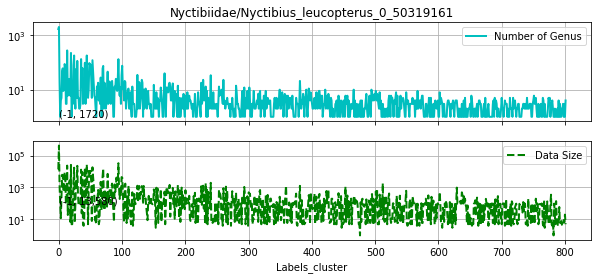

In [408]:
df_taxon['Label_cluster'] = df_taxon['Label_cluster'].astype(np.int32)
# labels_statistic['Genus_unique'] = df_taxon.groupby(['Label']).Genus.nunique()
# labels_statistic['Data_size'] = df_taxon.groupby(['Label']).ML_Catalog_Number.count()

labels_statistic = pd.concat([df_taxon.groupby(['Label_cluster']).Genus.nunique(),
                              df_taxon.groupby(['Label_cluster']).ML_Catalog_Number.count().rename('Data_szie')
                             ], axis=1)

fig, ax = plt.subplots(2,1, figsize=(10,4), sharex='col')
ax[0].plot(labels_statistic['Genus'], 'c', lw=2 , label='Number of Genus')
ax[1].plot(labels_statistic['Data_szie'], '--g', lw=2, label='Data Size' )
ax[0].grid(True); ax[1].grid(True); ax[0].legend(); ax[1].legend()
ax[0].set(yscale='log')
ax[1].set(xlabel='Labels_cluster', yscale='log',)
ax[0].set_title(f'{file_}')
plt.axis('tight')
ax[0].text(-.5, 1, f"(-1, {labels_statistic.Genus.loc[-1]})",  )
ax[1].text(-.5, 100, f'(-1, {labels_statistic.Data_szie.loc[-1]:,d})' )
;


### Check Genus number and Data size as Label is '-1'

In [622]:
%%time

method = "DBSCAN"

min_samples = 10
labels_statistics = [] 
for eps in np.arange(1,11)*0.1:
    if method == "OPTICS":
        max_eps = eps
        file_ = f'Clustering_labels_{method}_{min_samples}(min_sample){max_eps:3.1f}(max_eps)'
        save_path = Path(path_embeddings/'clustering_labels'/'All')
    elif method == "DBSCAN":
        file_ = f'Clustering_labels_{method}_{min_samples}(min_sample)_{eps:3.1f}(eps)'
        save_path = Path(path_embeddings/'clustering_labels'/'All')
    
    labels_cluster = np.load(save_path/f'{file_}.npz',)['labels']
    df_taxon = df_meta
    df_taxon['Label_cluster'] = labels_cluster 
    labels_statistic_ = pd.concat([df_taxon.groupby(['Label_cluster']).Genus.nunique(),
                              df_taxon.groupby(['Label_cluster']).ML_Catalog_Number.count().rename('Data_szie')
                             ], axis=1)
    labels_statistic_['n_Cluster'] = np.unique(labels_cluster).size
    labels_statistics.append(labels_statistic_.loc[-1].values) 
    # break
labels_statistics = (pd.DataFrame(labels_statistics, index=np.linspace(0.1,1.0,10))
                     .reset_index().set_axis(['eps','Genus_-1', 'Data_size_-1', 'n_Cluster'], axis=1 )
                    )
labels_statistics

CPU times: user 749 ms, sys: 19.7 ms, total: 769 ms
Wall time: 769 ms


,eps,Genus_-1,Data_size_-1,n_Cluster
0,0.1,1867,22033,777
1,0.2,817,2124,173
2,0.3,258,409,86
3,0.4,105,142,56
4,0.5,45,62,45
5,0.6,18,27,38
6,0.7,8,11,32
7,0.8,5,7,27
8,0.9,4,5,20
9,1.0,2,3,19


In [623]:
file_ = f'Clustering_labels_{method}_{min_samples}(min_sample)_{-1}(label)'
save_path = Path(path_embeddings/'clustering_labels')
save_path = save_path/f'{file_}.csv'
labels_statistics.to_csv(save_path)

#### def `plot_3DScatter_taxon()`

In [14]:
#  template ['ggplot2', 'seaborn', 'simple_white', 'plotly', 'plotly_white', 'plotly_dark', 'presentation', 'xgridoff', 'ygridoff', 'gridon', 'none']
def convert_binary_taxon(df, cls_, taxon) :
    df_temp = df.copy()
    df_temp[taxon] = np.where(df_temp[taxon] == cls_, cls_, 'Others' )
    # df_temp[taxon] = df_temp[taxon].astype('category')
    return df_temp


def plot_3DScatter_taxon(embedding, df:pd.DataFrame, taxon=taxon, monocolor:bool=False,
                       color_discrete_map:dict=None, 
                       opacity=0.8, width=1200, marker_size:int=2, save_file:str=None, **kwds ):
    
    df = convert_binary_taxon(df, cls_, taxon) if monocolor else df
        
    scatter_setting = dict(data_frame=embedding, x=0, y=1, z=2,
                       labels=dict(color=taxon), color=df['Label'],
                        # 設定游標顯示項目
                        hover_name= df.ML_Catalog_Number, 
                        hover_data=dict(Order=df.Order, Family=df.Family, Genus=df.Genus, 
                                        Sp=df.SCI_NAME_2021, Dir_FName=df.Dir_FName))
    if color_discrete_map is not None :
        scatter_setting.update(color_discrete_map=color_discrete_map)
        
    fig = px.scatter_3d(**scatter_setting)
    fig.update_layout(
        width=width, height=width*2/3, template='seaborn', 
        margin = dict(r=10, l=10, b=5, t=5),   # tight layout
        title = dict( text=title, x=0.5, y=0.9, font=dict(family="Arial", size=20,)),
        legend = dict(x=0.75, y=0.9, itemsizing = 'constant', bordercolor="Black", borderwidth=0.1),)
    fig.update_traces(marker_size=marker_size, opacity=opacity,)

    # fig.show()
    if save_file is not None:
        fig.write_html(save_file, auto_open=True)



In [368]:
taxon='Label_cluster'
cls_= '-1'
df_cod['Label_cluster'] = labels_cluster 
df_cod['Label_cluster'] = df_cod['Label'].astype('string')
df_taxon['Label_cluster'] =  df_taxon['Label'].astype('string')

color_discrete_map = {"Others": "lightgrey"}
# color_discrete_map = dict(zip(np.sort(df_taxon.loc[idx_sampled][taxon].unique()),
#                                        px.colors.qualitative.Vivid))

save_path = Path(f'embedding/umap_Cluster/{encoder_version}_{data_src}_{taxon}')
save_path.mkdir(exist_ok=True, parents=True)

title = f'{file_}_All_{cls_.capitalize()}(label)_{min_samples}(min_sample)'
subtitle = f'{n_neighbors}(n_nei)_{v_embedding}'
save_file = f'{save_path}/MC{n_components}D_{taxon}_{title}_{subtitle}.html'
title  += f'<br><sup>{subtitle}</sup>'       #  <br><sup>  </sup> start from next line 

idx_sampled = sample_nontarget_idx(df_cod ,  cls_=cls_, taxon=taxon, p=0.1)

plot_3DScatter_taxon(embedding_umap[idx_sampled],  df_taxon.loc[idx_sampled] ,taxon=taxon, 
                     monocolor=True, 
                     cls_=cls_,
                      color_discrete_map=color_discrete_map,
                   title=title, save_file=save_file,
                     marker_size=3, opacity=0.8, width=1500)

In [329]:
file_

'Clustering_labels_DBSCAN_77(min_sample)_0.1(eps)'

In [370]:
l_= '-1' 
files = df_taxon.query('Label ==  @l_').Dir_FName.values
print(len(files))

files = np.random.choice(files, 1000)

print(len(files))
dir_save =  Path(f'embedding/umap_Cluster/test_find_outlier/{file_}/{l_}')
dir_save.mkdir(exist_ok=True, parents=True) 

13580
1000


#### Sampling to view original images

 ## Check model Accuracy for data with Clustering Label "-1"

### def `filename2Labe():`

In [7]:

# def filename2Label(file_names:list, df_label:pd.DataFrame)->np.array:
#     mlcn_ = pd.Series(file_names).rename('ML_Catalog_Number').apply(lambda x : x.split('_')[-1] ).astype(np.int64)
#     labels = pd.merge(mlcn_, df_label, on ='ML_Catalog_Number').Label.values	
#     assert len(mlcn_) == len(labels), f'Number of "file_names" {len(FName_sp_)} is not equal "labels" {len(labels)}'
#     return labels




### Load encoder

In [11]:
# encoder_version='eBirdFT' # 'iNatFT', 'eBirdFT' or 'eBirdPT',
# norm_pixel = 'on'

# global_pool = False
# token = 'cls' if global_pool==False else 'gap'
# data_src = 'eBirdTop100' #  'iNat', 'eBird', 'eBirdTop100'

# print(f'Encoder  : {encoder_version}')
# if encoder_version=='iNatFT':
#     ck = Path('output_dir')/'ebird_NPon_FT_cls_vit_base_checkpoint-99.pth'   #　iNaturalist finetuned MAE
#     n_classes = 1486
# elif encoder_version=='eBirdPT':
#     ck = Path('output_dir')/'ebird_LP_cls_2fc_vit_base_checkpoint-89.pth'   #　Ebird pretrained MAE
#     n_classes =1486
# elif encoder_version=='eBirdFT':
#     ck = Path('output_dir')/'ebird_NPon_eBirdFT_cls_vit_base_checkpoint-149.pth'  #　eBird finetuned MAE
#     n_classes = 9484

v_embedding = f'NP{norm_pixel}(Pretrain)_{encoder_version}{token}(Encoder)_{data_src}(Data)'
print(f'Embedding version : {v_embedding}')

 

Embedding version : NPon(Pretrain)_eBirdFTcls(Encoder)_eBirdTop100(Data)


In [12]:

def load_encoder(ck, n_classes:int=1486, global_pool:bool=False, encoder_version:str='iNat_FT', **kwargs):
    # assert encoder_version == 'eBirdPT' or encoder_version =='iNatFT', f'Encoder_version must be either iNatFT or eBirdPT, got {encoder_version}'
    
    model = models_vit.__dict__['vit_base_patch16'](num_classes=n_classes, global_pool=global_pool, )
    checkpoint = torch.load(ck, map_location='cpu')
    checkpoint_model = checkpoint['model']
    state_dict = model.state_dict()

    # interpolate position embedding
    interpolate_pos_embed(model, checkpoint_model)

    # load pre-trained model
    msg = model.load_state_dict(checkpoint_model, strict=False)
    print(msg)
    return model

print(f"Load pre-trained checkpoint from: {ck}")
encoder = load_encoder(ck,n_classes=n_classes, encoder_version=encoder_version)



Load pre-trained checkpoint from: output_dir/ebird_NPon_eBirdFT_cls11186_vit_base_checkpoint-49.pth
<All keys matched successfully>


### Prepare dataset

In [8]:
%%time
method = "DBSCAN"

min_samples = 5
labels_statistics = [] 
eps = 0.1
if method == "OPTICS":
    max_eps = eps
    file_ = f'Clustering_labels_{method}_{min_samples}(min_sample){max_eps:3.1f}(max_eps)'
    save_path = Path(path_embeddings/'clustering_labels')
elif method == "DBSCAN":
    file_ = f'Clustering_labels_{method}_{min_samples}(min_sample)_{eps:3.1f}(eps)'
    save_path = Path(path_embeddings/'clustering_labels'/'all')

labels_cluster = np.load(save_path/f'{file_}.npz',)['labels']
df_taxon = df_meta
df_taxon['Label_cluster'] = labels_cluster 
print('Number of Labels : ', np.unique(labels_cluster).size)

# df_taxon = df_taxon.query('Label_cluster == -1')
label = -1
files_path_  = list(data_path + '/' +  val_data + '/' + df_taxon.query('Label_cluster == @label').Dir_FName	+ '.jpg')
labels = df_taxon.query('Label_cluster == @label').Label.values

assert len(files_path_) ==len(labels)

Number of Labels :  803
CPU times: user 385 ms, sys: 65.2 ms, total: 450 ms
Wall time: 448 ms


In [9]:

file_ = f'Clustering_labels_{method}_{min_samples}(min_sample)_{-1}(label)'
save_path = Path(path_embeddings/'clustering_labels'/'all')
save_path = save_path/f'{file_}.csv'
# labels_statistics.to_csv(save_path)
labels_statistics = pd.read_csv(save_path, index_col=0)
labels_statistics

,eps,Genus_-1,Data_size_-1,n_Cluster,acc1,acc5
0,0.1,1720,13580,803,15.907118,20.138889
1,0.2,635,1307,154,13.932292,16.666667
2,0.3,201,292,84,8.789063,10.156250
3,0.4,77,96,58,NaN,NaN
4,0.5,30,39,45,NaN,NaN
5,0.6,12,14,37,NaN,NaN
6,0.7,6,8,30,NaN,NaN
7,0.8,4,5,25,NaN,NaN
8,0.9,4,5,20,NaN,NaN
9,1.0,2,3,19,NaN,NaN


In [27]:
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
batch_size = 10
mean, std = IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
# simple augmentation
transform_toTensor = transforms.Compose([transforms.Resize(256, interpolation=PIL.Image.BICUBIC), 
                                         transforms.CenterCrop(224), 
                                         transforms.ToTensor(), 
                                         transforms.Normalize(mean, std)])

/home/esslab/anaconda3/envs/mae/lib/python3.9/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [13]:
dataset = util_datasets.ImageDatasetFromFile(files_path_, labels,  transform=transform_toTensor)
print(len(dataset))

# sampler = torch.utils.data.RandomSampler(dataset)
data_loader = torch.utils.data.DataLoader(dataset, pin_memory=False, drop_last=False, shuffle=True, num_workers=6,  batch_size=batch_size)

13580


### Evaluate

##### def `accuracy()`

In [14]:
def accuracy(output, target, topk=(1,), flag='accuracy'):
    """
    flag='accuracy' : Computes the accuracy over the k top predictions for the specified values of k
    flag='correct_label' : Return the correct_label over the k top predictions for the specified values of k
    """
    maxk = min(max(topk), output.size()[1])
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))
    accuracy = [correct[:min(k, maxk)].reshape(-1).float().sum(0) * 100. / batch_size for k in topk]
    correct_label = [correct[:min(k, maxk)].any(dim=0).type(torch.uint8) for k in topk]
    if flag=='accuracy':
        return accuracy
    elif flag=='correct_label':
        return correct_label

def get_global_mean(acc_list:list):
    acc_list[-1] = acc_list[-1] * batch_/batch_size
    return np.asarray(acc_list).mean()

In [ ]:
# # %%time
topk=(1, 5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder.eval()
encoder.to(device)

start_time = time.time()
for i, (imgs, target)  in enumerate(data_loader):
    target = target.to(device, non_blocking=True)
    imgs = imgs.to(device, non_blocking=True)
    
    with torch.no_grad():
        output = encoder(imgs)
    
    acc1, acc5  = accuracy(output, target, topk=topk, flag='accuracy')
    temp = accuracy(output, target, topk=topk, flag='correct_label')
    if i ==0:
        cor_labels = temp 
        
    else: 
        cor_labels = [torch.concat([cor_label_, temp[i]], dim=0)
                      for i, cor_label_ in enumerate(cor_labels) ]
        
    passing_time = str(datetime.timedelta(seconds=int(time.time() - start_time )))
    info = f'[{i:6,d}/{len(data_loader):,d}] {100*(i+1)/len(data_loader):4.1f}% '
    info += f'| Time: {passing_time} '
    info += f'| correct_labels : {len(cor_labels)} x {len(cor_labels[0])} '
    info += f'| Glocal Acc1 : {100 * cor_labels[0].type(torch.float).mean():.2f}%, Acc5 : {100 * cor_labels[1].type(torch.float).mean():.2f}% '
    info += f'| Batch Acc1 : {acc1:.2f}%, Acc5 : {acc5:.2f}% '
    print(info, end='\r')
    # if i==20:break
    # break


In [641]:
min_samples = 10
file_ = f'Clustering_labels_{method}_{min_samples}(min_sample)_{-1}(label)'
print(file_)
save_path = Path(path_embeddings/'clustering_labels')
save_path = save_path/f'{file_}.csv'
# labels_statistics.to_csv(save_path)
labels_statistics = pd.read_csv(save_path, index_col=0)
idx = labels_statistics.query('eps == @eps').index.values
labels_statistics.loc[idx, ['acc1', 'acc5']] = acc_top1_mean, acc_top5_mean, 

labels_statistics.to_csv(save_path)
labels_statistics = pd.read_csv(save_path, index_col=0)
labels_statistics

Clustering_labels_DBSCAN_10(min_sample)_-1(label)


,eps,Genus_-1,Data_size_-1,n_Cluster,acc1,acc5
0,0.1,1867,22033,777,15.952766,20.321480
1,0.2,817,2124,173,14.453125,17.534722
2,0.3,258,409,86,12.500000,14.648438
3,0.4,105,142,56,NaN,NaN
4,0.5,45,62,45,NaN,NaN
5,0.6,18,27,38,NaN,NaN
6,0.7,8,11,32,NaN,NaN
7,0.8,5,7,27,NaN,NaN
8,0.9,4,5,20,NaN,NaN
9,1.0,2,3,19,NaN,NaN


In [621]:
min_samples = 5
file_ = f'Clustering_labels_{method}_{min_samples}(min_sample)_{-1}(label)'
print(file_)
save_path = Path(path_embeddings/'clustering_labels')
save_path = save_path/f'{file_}.csv'
# labels_statistics.to_csv(save_path)
# labels_statistics = pd.read_csv(save_path, index_col=0)
# idx = labels_statistics.query('eps == @eps').index.values
# labels_statistics.loc[idx, ['acc1', 'acc5']] = acc_top1_mean, acc_top5_mean, 

# labels_statistics.to_csv(save_path)
labels_statistics = pd.read_csv(save_path, index_col=0)
labels_statistics

Clustering_labels_DBSCAN_5(min_sample)_-1(label)


,eps,Genus_-1,Data_size_-1,n_Cluster,acc1,acc5
0,0.1,1720,13580,803,15.907118,20.138889
1,0.2,635,1307,154,13.932292,16.666667
2,0.3,201,292,84,8.789063,10.156250
3,0.4,77,96,58,NaN,NaN
4,0.5,30,39,45,NaN,NaN
5,0.6,12,14,37,NaN,NaN
6,0.7,6,8,30,NaN,NaN
7,0.8,4,5,25,NaN,NaN
8,0.9,4,5,20,NaN,NaN
9,1.0,2,3,19,NaN,NaN


### 小結
- 使用DBSCAN分群
    - 參數
        - eps(半徑、兩樣本之間的最大距離) 與 min_sample(最小核心點樣本數)設的越小，分群數量越多
        - min_sample越大、eps越小時，未被納入分群中的離群數量越多
    - 前提
        - embedding 經過UMAP降維後，理論上同一分類單元的資料會盡可能聚集，難以區別的資料則會盡可能被推離
    - 結果
        - min_samples = 10
            - eps = 0.1 and Label ='-1'
                - n_Genus = 1867, data_size = 22,033(2.46%), n_cluster=777
                - acc_top1, acc_top5 = 15.95%, 20.32%
        - min_samples = 5
            - eps  =0.1 and Label ='-1'
                - n_Genus = 1720, data_size = 13,580(1.50%), n_cluster=803
                - acc_top1, acc_top5 = 15.91%, 20.13%
    - 討論
        - 在 min_samples 設置較小範圍時(5, 10)，未被歸類的樣本(Label = -1)達到合理的數量(期望數量為總資料量的3.27%，29k)，與相當高的"屬"數量 
        - 但在分類正確率上， top5分類正確率仍在20%左右，未達到期望的1%，顯示目前分群結果，未被歸類的類別有很高的比例，仍可被模型辨識
        - 有些被歸類為特定標籤的資料可能也是難以辨識的? 例如都是雜亂背景的、有大片天空的?
            - [ ] 檢視所有分群的分類正確率(eps=1)  

        
    

## Find the top5 prediction errors and view their embedding


### Prepare dataset

In [24]:
%%time

data_path = '../../shared/iNaturalist_2021'

if data_src == 'eBird':
    val_data = 'val_ebird'
    meta_data =  '../../shared/iNaturalist_2021/meta/val_ebird.csv'
elif data_src == 'iNat':
    val_data = 'val'
    meta_data =  '../../shared/iNaturalist_2021/meta/val.csv'
elif  data_src == 'eBirdTop100':
    data_path = '../../shared/eBird/download_ebird/downloaded'
    val_data = 'jpg_top100'
    meta_data =  '../../shared/eBird/download_ebird/meta/jpg_top100_meta5.csv'
    
# val_data = 'ebird_finetune/train'
# imgs_path = Path(data_path, val_data)
# # imgs_path = Path('../../shared/iNaturalist_2021/val_ebird')
# print(imgs_path)
# files_path_ = [f for f in imgs_path.glob('**/*') if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]

# # exlude .ipynb files
# files_path_ = [f for f in files_path_ if not f.name.startswith('.')] 
# files_path_.sort()

# print(f'Meta data :  "{Path(meta_data).name}"')


files_path_  = list(data_path + '/' +  val_data + '/' + df_meta.Dir_FName	+ '.jpg')
labels = df_meta.Label.values

print(len(files_path_ ))
assert len(files_path_) == len(labels)
assert  df_meta.Label.dtype == 'int64'

896555
CPU times: user 184 ms, sys: 52.3 ms, total: 236 ms
Wall time: 235 ms


In [29]:
batch_size = 1000
# s = 150000
dataset = util_datasets.ImageDatasetFromFile(files_path_, labels, transform=transform_toTensor)
# dataset = util_datasets.ImageDatasetFromFile(np.random.choice(files_path_, 5000), transform=transform_toTensor)
# dataset = util_datasets.ImageDatasetFromFile(files_path_[s:s+batch_size], transform=transform_toTensor)
print(len(dataset))

# sampler = torch.utils.data.RandomSampler(dataset)
data_loader = torch.utils.data.DataLoader(dataset, pin_memory=True, 
                                          drop_last=False, shuffle=False, 
                                          num_workers=10,  batch_size=batch_size)
print(len(data_loader))

896555
897


In [117]:
# batch_size = 500
# dataset = datasets.ImageFolder(imgs_path, transform=transform_toTensor)
# print(len(dataset))

# # sampler = torch.utils.data.RandomSampler(dataset)
# data_loader = torch.utils.data.DataLoader(dataset, pin_memory=True, drop_last=False, shuffle=True, num_workers=10,  batch_size=batch_size)
# print(len(data_loader))

173936
348


- df_label資料有問題
    - 在類別與標籤對應時出問題
- 直接用 datasets.ImageFolde也是可以取得預測結果
- 使用dataset.samples可以直接取得完整標籤

In [30]:
# # %%time
topk=(1, 5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder.eval()
encoder.to(device)

start_time = time.time()
for i, (imgs, target)  in enumerate(data_loader):
    target = target.to(device, non_blocking=True)
    imgs = imgs.to(device, non_blocking=True)
    
    with torch.no_grad():
        output = encoder(imgs)
    
    acc1, acc5  = accuracy(output, target, topk=topk, flag='accuracy')
    temp = accuracy(output, target, topk=topk, flag='correct_label')
    if i ==0:
        cor_labels = temp 
        
    else: 
        cor_labels = [torch.concat([cor_label_, temp[i]], dim=0)
                      for i, cor_label_ in enumerate(cor_labels) ]
        
    passing_time = str(datetime.timedelta(seconds=int(time.time() - start_time )))
    info = f'[{i:6,d}/{len(data_loader):,d}] {100*(i+1)/len(data_loader):4.1f}% '
    info += f'| Time: {passing_time} '
    info += f'| correct_labels : {len(cor_labels)} x {len(cor_labels[0])} '
    info += f'| Glocal Acc1 : {100 * cor_labels[0].type(torch.float).mean():.2f}%, Acc5 : {100 * cor_labels[1].type(torch.float).mean():.2f}% '
    info += f'| Batch Acc1 : {acc1:.2f}%, Acc5 : {acc5:.2f}% '
    print(info, end='\r')
    # if i==20:break
    # break


- merge to data

In [87]:
# df_correct_ = (pd.concat([pd.Series(score.cpu().numpy())  
#                      for score in  cor_labels], 
#           axis=1)
#           .set_axis(['acc1', 'acc5'], axis=1))
# print(df_correct_.mean())
# df_correct = pd.concat([df_meta.ML_Catalog_Number, df_correct_], axis=1) 
path_correct = 'meta/correct.csv'
# df_correct.to_csv(path_correct)
df_correct = pd.read_csv(path_correct, index_col=0)
df_correct = pd.concat([df_correct, df_meta[col_label + col_taxon]], axis=1)
df_correct 

,ML_Catalog_Number,acc1,acc5,Label,Order,Family,Genus,SCI_NAME_2021,Sci_Name,Parent_Species,Taxon_Category
0,114289801,1,1,3090,Passeriformes,Acanthisittidae,Acanthisitta,Acanthisitta chloris,Acanthisitta chloris,Acanthisitta chloris,Species
1,114289821,1,1,3090,Passeriformes,Acanthisittidae,Acanthisitta,Acanthisitta chloris,Acanthisitta chloris,Acanthisitta chloris,Species
2,114404941,1,1,3090,Passeriformes,Acanthisittidae,Acanthisitta,Acanthisitta chloris,Acanthisitta chloris,Acanthisitta chloris,Species
3,114404951,1,1,3090,Passeriformes,Acanthisittidae,Acanthisitta,Acanthisitta chloris,Acanthisitta chloris,Acanthisitta chloris,Species
4,115495451,1,1,3090,Passeriformes,Acanthisittidae,Acanthisitta,Acanthisitta chloris,Acanthisitta chloris,Acanthisitta chloris,Species
...,...,...,...,...,...,...,...,...,...,...,...
896550,59630711,1,1,9660,Passeriformes,Zosteropidae,Zosterornis,Zosterornis whiteheadi,Zosterornis whiteheadi,Zosterornis whiteheadi,Species
896551,59630721,1,1,9660,Passeriformes,Zosteropidae,Zosterornis,Zosterornis whiteheadi,Zosterornis whiteheadi,Zosterornis whiteheadi,Species
896552,63554951,1,1,9660,Passeriformes,Zosteropidae,Zosterornis,Zosterornis whiteheadi,Zosterornis whiteheadi,Zosterornis whiteheadi,Species
896553,79738531,1,1,9660,Passeriformes,Zosteropidae,Zosterornis,Zosterornis whiteheadi,Zosterornis whiteheadi,Zosterornis whiteheadi,Species


### check Accuracy performance by taxon unit

#### Order
- 表現較差的依序為Procellariiformes鸌形目(91.16%)、Anseriformes雁形目(91.63%)、Caprimulgiformes夜鷹目(91.74%)

In [79]:
df_correct.query('Label>0').groupby(['Order'])[['acc1', 'acc5']].agg(['mean', 'count']).sort_values(('acc1', 'mean'))

acc1              acc5        
                         mean   count      mean   count
Order                                                  
Procellariiformes    0.911640   13445  0.974414   13445
Anseriformes         0.916366   27680  0.982370   27680
Caprimulgiformes     0.917415   49573  0.972122   49573
Suliformes           0.920647    6805  0.976929    6805
Apterygiformes       0.923567     157  0.993631     157
Accipitriformes      0.925595   27189  0.974843   27189
Podicipediformes     0.930204    2450  0.992653    2450
Charadriiformes      0.935010   47038  0.983524   47038
Gaviiformes          0.945794     535  0.986916     535
Passeriformes        0.950296  503103  0.984856  503103
Cuculiformes         0.950558   12176  0.986777   12176
Phoenicopteriformes  0.951220     615  0.990244     615
Bucerotiformes       0.951799    5809  0.990188    5809
Tinamiformes         0.952075    2337  0.984596    2337
Columbiformes        0.953433   20916  0.985705   20916
Psittaciformes       0.954812   26733  0.985037   26733
Pelecaniformes       0.956244   14398  0.991249   14398
Sphenisciformes      0.957613    1793  0.987730    1793
Piciformes           0.960504   36257  0.991698   36257
Strigiformes         0.960609   18075  0.990318   18075
Falconiformes        0.960863    8253  0.986187    8253
Otidiformes          0.962886    2398  0.990826    2398
Coliiformes          0.966942     484  0.991736     484
Trogoniformes        0.968270    4885  0.998976    4885
Ciconiiformes        0.968411    2121  0.993871    2121
Gruiformes           0.969192   13860  0.993074   13860
Galliformes          0.969959   20838  0.989874   20838
Struthioniformes     0.970588     204  0.995098     204
Musophagiformes      0.973481    1810  0.993370    1810
Coraciiformes        0.974431   14236  0.995575   14236
Cathartiformes       0.975758     990  0.993939     990
Pterocliformes       0.979287    1738  0.989068    1738
Galbuliformes        0.984089    5405  0.995930    5405
Casuariiformes       0.985915     213  0.995305     213
Leptosomiformes      0.990000     100  1.000000     100
Phaethontiformes     0.991736     484  1.000000     484
Cariamiformes        0.995000     200  1.000000     200
Mesitornithiformes   0.996016     251  1.000000     251
Rheiformes           0.996942     327  1.000000     327
Opisthocomiformes    1.000000     100  1.000000     100
Eurypygiformes       1.000000     200  1.000000     200

#### Family
- 表現最差的依序為Apodidae雨燕科(76.76%)、Hydrobatidae海燕科(85.16%)、Eulacestomatidae
    - 雨燕科背景為非天空的被明顯分在獨立一小群

In [78]:
df_correct.query('Label>0').groupby(['Family'])[['acc1', 'acc5']].agg(['mean', 'count']).sort_values(('acc1', 'mean')) 

acc1            acc5      
                      mean count      mean count
Family                                          
Apodidae          0.767654  7123  0.912537  7123
Hydrobatidae      0.851586  1671  0.957510  1671
Eulacestomatidae  0.864865    37  0.918919    37
Calyptophilidae   0.875000    64  0.968750    64
Stercorariidae    0.875962  1169  0.979470  1169
...                    ...   ...       ...   ...
Sapayoidae        1.000000   100  1.000000   100
Scopidae          1.000000    97  1.000000    97
Semnornithidae    1.000000   199  1.000000   199
Eupetidae         1.000000    65  1.000000    65
Zeledoniidae      1.000000   100  1.000000   100

[249 rows x 4 columns]

#### Genus
- 表現最差的依序為Camptorhynchus拉布拉多鸭属(50.00%), Hydrochous瀑布雨燕属(50.00%)	Schoutedenapus雨燕属(62.16%)

In [77]:
df_correct.query('Label>0').groupby(['Genus'])[['acc1', 'acc5']].agg(['mean', 'count']).sort_values(('acc1', 'mean')) 

acc1            acc5      
                    mean count      mean count
Genus                                         
Camptorhynchus  0.500000     2  1.000000     2
Hydrochous      0.500000    18  0.722222    18
Schoutedenapus  0.621622    37  0.945946    37
Phasianidae     0.625000     8  1.000000     8
Oreophilais     0.636364    11  0.818182    11
...                  ...   ...       ...   ...
Madanga         1.000000     8  1.000000     8
Erithacus       1.000000   100  1.000000   100
Heinrichia      1.000000     4  1.000000     4
Corythaixoides  1.000000   315  1.000000   315
Zosterornis     1.000000    53  1.000000    53

[2295 rows x 4 columns]

In [104]:
temp = (df_correct.query('Label>0').groupby(['Label', 'Parent_Species'])
 [['acc1', 'acc5']].agg(['mean', 'count']).sort_values(('acc1', 'mean')))
 # .head(10) 
mask = temp.loc[:,('acc1','count')]>3
temp[mask][:20]

acc1        \
                                                            mean count   
Label Parent_Species                                                     
10255 Oceanodroma leucorhoa/socorroensis (dark-rumped)  0.285714     7   
6781  Junco hyemalis/phaeonotus                         0.290323    31   
377   Anser sp.                                         0.300000    40   
717   Apus sp.                                          0.333333    72   
3567  Chloropsis jerdoni/aurifrons                      0.357143    14   
724   Chaetura martinica                                0.384615    26   
10241 Thalassarche cauta/salvini/eremita                0.384615    13   
699   Apus apus/pallidus                                0.410000   100   
9699  Egretta garzetta/gularis                          0.434783    23   
521   Oxyura ferruginea/vittata                         0.437500    16   
10851 Glaucidium cuculoides/radiatum                    0.454545    11   
7669  Rhipidura albogularis/aureola                     0.466667    15   
700   Apus balstoni                                     0.476190    21   
776   Zoonavena grandidieri                             0.476190    21   
6527  Poecile atricapillus/gambeli                      0.478261    23   
235   Milvus milvus/migrans                             0.478261    23   
10034 Dryobates pubescens/villosus                      0.490000   100   
6042  Muscicapa dauurica/williamsoni                    0.500000    12   
747   Cypseloides rothschildi                           0.500000    24   
756   Hydrochous gigas                                  0.500000    18   

                                                            acc5        
                                                            mean count  
Label Parent_Species                                                    
10255 Oceanodroma leucorhoa/socorroensis (dark-rumped)  0.714286     7  
6781  Junco hyemalis/phaeonotus                         1.000000    31  
377   Anser sp.                                         0.750000    40  
717   Apus sp.                                          0.833333    72  
3567  Chloropsis jerdoni/aurifrons                      0.785714    14  
724   Chaetura martinica                                0.615385    26  
10241 Thalassarche cauta/salvini/eremita                0.538462    13  
699   Apus apus/pallidus                                0.830000   100  
9699  Egretta garzetta/gularis                          0.826087    23  
521   Oxyura ferruginea/vittata                         0.625000    16  
10851 Glaucidium cuculoides/radiatum                    0.909091    11  
7669  Rhipidura albogularis/aureola                     0.866667    15  
700   Apus balstoni                                     0.714286    21  
776   Zoonavena grandidieri                             0.714286    21  
6527  Poecile atricapillus/gambeli                      0.695652    23  
235   Milvus milvus/migrans                             0.782609    23  
10034 Dryobates pubescens/villosus                      0.970000   100  
6042  Muscicapa dauurica/williamsoni                    0.583333    12  
747   Cypseloides rothschildi                           0.541667    24  
756   Hydrochous gigas                                  0.722222    18

---

## 分群探索檢視資料輪廓
- 分群結果受影像背景影響大
    - 同一類群內如果有明顯不同群集，可能反應圖片背景 > 主體特徵  
- 如果主體特徵凸顯，則可能得到非常聚集的embedding

-
- 

## 在計算型態多樣性數值時，如何排除背景圖片的影響?
- 當各分類單元資料量大時，可能可以藉由大量資料消弭背景圖片影響?
- 找出分類的關鍵維度，僅計算關鍵維度的容量?

- 各分類單元是否存有背景圖片的系統性偏差?
- 運用分群找outlier的方法並無法良好的將outlier資料對應到"品質不好"的資料
    - 如何定義品質不好
    - 有些資料空間分布就是分散，但不見得品質不佳、或著資料量少，可能多數都是品質不佳的資料
 

---

#　View representative sample of cluster centroid of each taxon unit(Family)

In [174]:
taxon = 'Family'
cls_list = np.sort(df_meta[taxon].dropna().unique())
print(len(cls_list))

249


- 抽樣原始影像
- 繪製質心圖

#### `def plot3dCluster()`

In [175]:

method = 'DBSCAN' # 'BIRCH'

taxon = 'Family'
q=0.5

if method == 'BIRCH' :
    T = 0.5
    save_path = Path(f'embedding/Cluster/{method} _{taxon}/')
elif method ==  "DBSCAN"  :
    min_samples=3
    save_path = Path(f'embedding/Cluster/{method}_{q}(quantile)_{taxon}/')

if not save_path.exists():
    save_path.mkdir(parents=True)
    print(f'{save_path} maked')
    

embedding/Cluster/DBSCAN_0.5(quantile)_Family maked


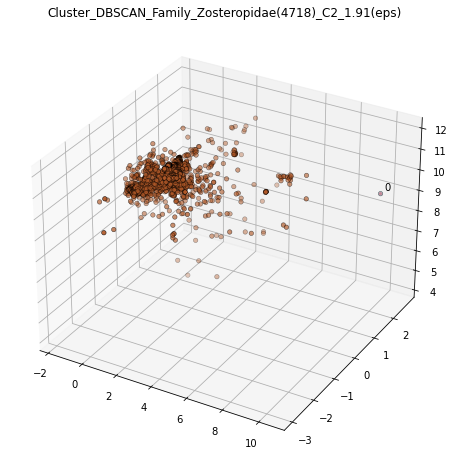

In [176]:
def plot3dCluster(embedding_umap, save_path:str=None, figsize=(8,8)):
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection='3d')
    if method == 'BIRCH':
        title = f'Cluster_{method}_{T}(T){taxon}_{cls_}({n_taxon})_C{len(label_list)}'
    elif method == 'DBSCAN':
        title = f'Cluster_{method}_{taxon}_{cls_}({n_taxon})_C{len(label_list)}_{eps:.2f}(eps)'
    ax.set_title(title);

    # plot data by labels
    x, y, z = [embedding_umap[index_cls_][:,d] for d in range(3)]
    ax.scatter3D(x, y, z, c=label_, cmap='Paired', edgecolor='black', linewidth=0.5)
    
    # plot cluster centroid 

    c_x, c_y, c_z = [np.asarray(centroid)[:,d] for d in range(3)]  # centroid for cluster
    ax.scatter3D(c_x, c_y, c_z, 'o', color='red', s=5, )
    # add text(labels)
    for l_  in label_list:
        c_x, c_y, c_z = centroid[l_]
        ax.text(c_x+.1, c_y+.1, c_z+.1, f"{l_}", transform=ax.transData)
    if save_path is not None:
        fig.savefig(save_path/f'{title}.jpg', bbox_inches='tight')
    ;

plot3dCluster(embedding_umap, save_path=save_path)

#### `def cal_eps_pwdis()`

In [177]:
# (for ODBSCAN)
# calulate paiwwise distance of taxon unit

from sklearn.metrics import pairwise_distances
def cal_eps_pwdis(embedding_:np.ndarray, q:float=0.9)->float:
    metric="euclidean"  # "euclidean"
    distances_matrix = pairwise_distances(embedding_,   metric=metric)
    eps_q = np.quantile(np.unique(distances_matrix), q=q)   # quantile 10% 
    if eps_q < 0.01:
        eps_q = 0.01
    return eps_q

#### Sampling data close to the center of the cluster
- The data of each category is sorted by the distance from the center of the category.
- For each category, n images are sampled in order of distance from the center.
- If the number of data in the category is less than n, all data in the category will be sampled.

#### `def get_cluster_centroid()`

In [178]:
def get_cluster_centroid(embedding_:np.ndarray, label_)->np.ndarray:
    centroids = []
    for l_ in sorted(np.unique(label_)):
        mask = label_==l_
        centroid_ = embedding_[mask].mean(axis=0)
        centroids.append(centroid_)
    return centroids 

### Sampling idx on each class and label

In [229]:
%%time

n_smp = 8

cls_labels_idx = {}
eps_q = []
for i, cls_ in enumerate(cls_list):
    print(i, cls_, end='\r')
    
    mask_cls = df_meta[taxon] == cls_
    index_cls_ = df_meta[mask_cls].index.values
    n_taxon = index_cls_.size
    
    if method == 'BIRCH':
        brc = Birch(threshold=T, n_clusters=None).fit(embedding_umap[index_cls_])
        label_ = brc.predict(embedding_umap[index_cls_])
    elif method == "DBSCAN" :
        eps = cal_eps_pwdis(embedding_umap[index_cls_], q=q)
        eps_q.append(eps)
        clustering  = DBSCAN(eps=eps, min_samples=min_samples).fit(embedding_umap[index_cls_])
        label_ = clustering.labels_

    label_list, label_count = np.unique(label_, return_counts=True)
    
    centroid =  brc.subcluster_centers_ if method == 'BIRCH' else get_cluster_centroid(embedding_umap[index_cls_], label_) 
    cls_labels_idx_ = {}
    for l_ in label_list:
            
        mask_label_ =  label_ == l_
        idx_label_ =  index_cls_[mask_label_] # get absolute "index" from df_meta == cls_
        
        # Sort data(index) closest to the centroid
        
        if method == 'BIRCH':
            distance = np.linalg.norm(embedding_umap[idx_label_] - centroid[l_] , axis=1)
        elif method == "DBSCAN" :
            distance = np.linalg.norm(embedding_umap[idx_label_] - centroid[l_] , axis=1)
        
        idx_sort = np.argsort(distance)                           # sort by distance from centroid)
        cls_labels_idx_[str(l_)] =  list(idx_label_[idx_sort[:n_smp]])  # get sorted index
        # break
    
    cls_labels_idx[cls_] = cls_labels_idx_ 

    plot3dCluster(embedding_umap, save_path=save_path, figsize=(12,12))
    plt.close()

    # if i==5: break

CPU times: user 52min 9s, sys: 48min 12s, total: 1h 40min 21s
Wall time: 26min 48s


In [237]:
file_ = f'cls_labels_idx_{q}(quantile).csv'

df_cls_labels_idx = pd.DataFrame(cls_labels_idx.values(), index=cls_labels_idx.keys())
df_cls_labels_idx.to_csv(save_path/file_)
df_cls_labels_idx = pd.read_csv(save_path/file_, index_col=0)

def cls_labels_idx_df2dict(df_:pd.DataFrame=None):
    cls_labels_idx  = {} 
    for rows_ in df_.itertuples():
        key_, *values_ = rows_
        values_ = [v for v in  values_ if str(v) != 'nan' ] 

        labels_idx_ = {}
        if len(values_) == 1:
            labels_idx_['0'] = values_[0]
        else :
            for l_ in range(-1, len(values_)-1):
                labels_idx_[str(l_)] = values_[l_]
        cls_labels_idx [key_] = labels_idx_

    return cls_labels_idx

cls_labels_idx_ = cls_labels_idx_df2dict(df_cls_labels_idx)

In [ ]:
cls_labels_idx_

In [181]:

# df_cls_labels_idx = pd.DataFrame(cls_labels_idx.values(), index=cls_labels_idx.keys()).reset_index()
# df_cls_labels_idx.to_feather(save_path/f'cls_labels_idx_{q}(quantile).feather')

# pd.read_feather(save_path/f'cls_labels_idx_{q}(quantile).feather')

### plot imgs by class and labels

#### `def plot_cluster_sample()`

In [182]:
root = '../../shared/eBird/download_ebird/downloaded/jpg_top100/'
cols_meta = ['ML_Catalog_Number', 'Dir_FName', 'Genus']
def get_meta(idx_, df_meta, cols=cols_meta):
    meta_ = df_meta.loc[idx_]
    mlcns_, fname_, genus_ = [meta_.loc[:, col_].values for col_ in cols]
    paths_ = root + fname_ + '.jpg'
    return mlcns_, genus_, paths_

In [183]:
def load_img(path:str=None, w:int=256 ):
    img = Image.open(path)
    w_o, h_o = img.size
    h = int(w*h_o/w_o)
    return img.resize((w, h))

CPU times: user 572 ms, sys: 214 ms, total: 786 ms
Wall time: 536 ms


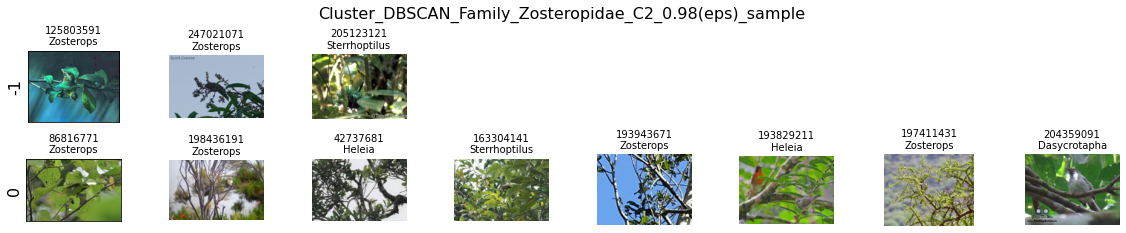

In [231]:
%%time
def plot_cluster_sample(n_label_:int=None, n_smp:int=n_smp, metas_:list=None, save_path:str=None):
    rows, cols = n_label_, n_smp

    figsize = (cols*2, 1 + rows*1.2)
    fig, axs = plt.subplots(rows, cols, figsize=figsize)
    if method == 'BIRCH':
        title = f'Cluster_{method}_{T}(T){taxon}_{cls_}_C{n_label_}_sample'
    elif method == 'DBSCAN':
        title = f'Cluster_{method}_{taxon}_{cls_}_C{n_label_}_{eps:.2f}(eps)_sample'

    fig.suptitle(f'{title}', fontsize=16, y=1.01)
    fig.tight_layout()
    
    if n_label_==1 :
        axs = axs.reshape(1,-1)      # if n_label_==1, "IndexError: list index out of range"
    
    label_list = list(cls_labels_idx_[cls_].keys())
    for row_, (label_, ax_)  in enumerate(zip(label_list, axs)):
        # row as label
        mlcns_, genus_, paths_ = metas_[row_]  
        for col, ax in enumerate(ax_):
            # ax.set_xticks([])
            # ax.set_yticks([])
            if col==0:
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_ylabel(label_, fontsize=16)
            else:
                ax.axis('off')

            if col < len(paths_):
                # print(f'{l_:2d} : {mlcns_[col]}, {genus_[col]:15s}')
                img = load_img(paths_[col], 128)
                ax.set_title(f'{mlcns_[col]}\n{genus_[col]}', fontsize=10)
                ax.imshow(img)
    if save_path is not None:
        fig.savefig(save_path/f'{title}.jpg', bbox_inches='tight')          
plot_cluster_sample(n_label_=n_label_, metas_=metas_, save_path=save_path)
    

In [240]:
%%time
for i, cls_ in enumerate(cls_list):

    print(i, cls_, '\r')
    query_ = cls_labels_idx_[cls_]

    idxs_ = list(query_.values())  # {label : idxs} by cls_
    n_label_ = len(query_)          # number of labels
    metas_ = [get_meta(idx_, df_meta, cols_meta) for idx_ in idxs_]   # [[mlcns_, genus_, paths_]., [...]]
    if method == 'DBSCAN':
        eps = eps_q[i]
    plot_cluster_sample(n_label_=n_label_, metas_=metas_, save_path=save_path)
    plt.close()


218 Stercorariidae 
219 Strigidae 
220 Strigopidae 
221 Struthionidae 
222 Sturnidae 
223 Sulidae 
224 Sylviidae 
225 Teretistridae 
226 Thamnophilidae 
227 Thinocoridae 
228 Thraupidae 
229 Threskiornithidae 
230 Tichodromidae 
231 Timaliidae 
232 Tinamidae 
233 Tityridae 
234 Todidae 
235 Trochilidae 
236 Troglodytidae 
237 Trogonidae 
238 Turdidae 
239 Turnicidae 
240 Tyrannidae 
241 Tytonidae 
242 Upupidae 
243 Urocynchramidae 
244 Vangidae 
245 Viduidae 
246 Vireonidae 
247 Zeledoniidae 
248 Zosteropidae 
CPU times: user 5min 37s, sys: 48.5 s, total: 6min 26s
Wall time: 5min 24s
